# Extracting an Emission Surface

In this notebook we'll walk through how you can extract an emission surface from an image cube following the method presented in [Pinte et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018A%26A...609A..47P/abstract). For this example we'll use the DSHARP CO data of HD 163296, presented in [Isella et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..49I/abstract) and available from the [DSHARP website](https://almascience.eso.org/almadata/lp/DSHARP/). Note that this is a bit of a chunky file, so make sure you have space for it!

First we start off with the standard imports.

In [1]:
from diskprojection import disk_observation
import matplotlib.pyplot as plt
import numpy as np

Now we want to load up the data: simply point `disk_observation` to the FITS cube. If the cube is large (as is the case for the DSHARP dataset), you can provide a field of view, `FOV`, and a velocity range, `velocity_range`, which will cut down the data array to only the region you're interested in. This can save a lot of computational time later on.

In [2]:
directory = '/Users/rteague/Projects/MAPS_DynamicalStructures/data/HD163296/v3/12CO/'
file = 'HD_163296_CO_220GHz.clean.r05.JvMcorr.image.fits'
cube = disk_observation(directory+file, FOV=10.0, velocity_range=[-3e3, 15e3])

With these commands we cut out a region that is $\pm 5^{\prime\prime}$ around the image center, and taking channels between $-3~{\rm km\,s^{-1}}$ and  $+15~{\rm km\,s^{-1}}$.

We also want some idea of the geometry of the system, namely the inclination, `inc`, and position angle, `PA` of the disk. Adopting those from fits of the continuum emission are just fine here.

In [3]:
inc = 37.4  # deg
PA = 312.0  # deg

With these values to hand, we can apply the emission surface extraction method to the entire data cube with the `get_emission_surface` function. This will return a `surface` class which contains the extracted emission surface. It will have contain arrays of the radial and vertical coordinates, `r` and `z`, the emission intensity at that point, `Inu`, and the velocity of the channel that this point was extracted from, `v`.

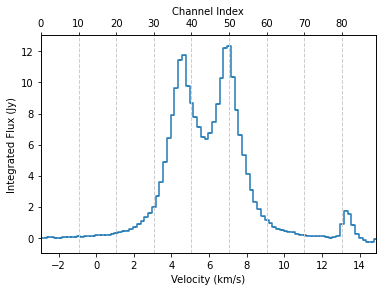

In [4]:
cube.plot_spectrum(inc=inc, PA=PA)

In [5]:
surface = cube.get_emission_surface(inc=inc, PA=PA, chans=[31, 55], r_max=4.0, smooth=0.5)

Rotating data cube...
Detecting peaks...


A quick way to see your extracted surface is with the `plot_surface` function.

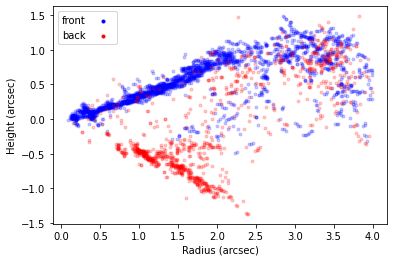

In [6]:
surface.plot_surface()

There are quite a few groups of points that can be seen. [Something MORE HERE]

We can now use our physical intuition to remove some of these noisy points. The most straightforward and easy-to-defend cut is simply making cuts in $z \, / \, r$ -  we know that the aspect ratio of the disk can't be greater than one (at least is most cases), and it shouldn't be negative. We can use the `mask_surface` function to apply these cuts to the `zr` attribute.

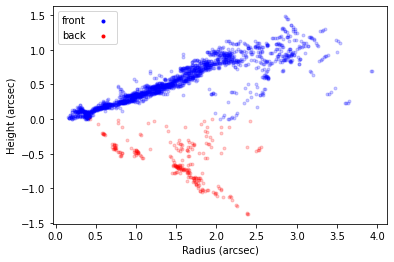

In [7]:
surface.mask_surface(side='both', min_z=0.0, min_SNR=25.0, reflect=True)
surface.plot_surface()

In [8]:
#cube.plot_peaks(surface=surface)

This is a good start and has removed a lot of the fluff around the emisison surface, leaving quite a distinct emission surface in the inner $\sim 3^{\prime\prime}$.

In [9]:
#cube.plot_isovelocities(surface=surface, mstar=2.0, dist=101.0, vlsr=5.7e3, side='both', smooth=5)

<ErrorbarContainer object of 3 artists>

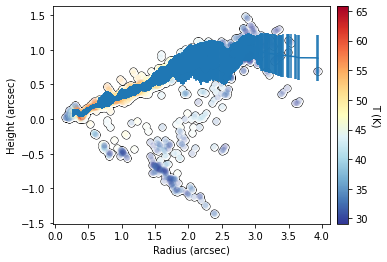

In [10]:
fig = cube.plot_temperature(surface=surface, return_fig=True)

r, z, dz = surface.rolling_surface(side='both', reflect=True)

fig.axes[0].errorbar(r, z, dz)